# Deep Kernel Learning

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/KernelFunctions.jl/blob/master/examples/deep-kernel-learning/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/deep-kernel-learning/).*

!!! warning
    This example is under construction

Setup

In [1]:
using KernelFunctions
using MLDataUtils
using Zygote
using Flux
using Distributions, LinearAlgebra
using Plots

Flux.@functor SqExponentialKernel
Flux.@functor KernelSum
Flux.@functor Matern32Kernel
Flux.@functor FunctionTransform

set up a kernel with a neural network feature extractor:

In [2]:
neuralnet = Chain(Dense(1, 3), Dense(3, 2))
k = SqExponentialKernel() ∘ FunctionTransform(neuralnet)

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Function Transform: Chain(Dense(1, 3), Dense(3, 2))

Generate date

In [3]:
xmin = -3;
xmax = 3;
x = range(xmin, xmax; length=100)
x_test = rand(Uniform(xmin, xmax), 200)
x, y = noisy_function(sinc, x; noise=0.1)
X = RowVecs(reshape(x, :, 1))
X_test = RowVecs(reshape(x_test, :, 1))
λ = [0.1]

1-element Vector{Float64}:
 0.1

In [4]:
f(x, k, λ) = kernelmatrix(k, x, X) / (kernelmatrix(k, X) + exp(λ[1]) * I) * y
f(X, k, 1.0)

100-element Vector{Float64}:
  0.05063713782810365
  0.042634741473957044
  0.03406007462230599
  0.025003685400102952
  0.015571822255904845
  0.005886012483588873
 -0.00391766844402251
 -0.013689646615509317
 -0.023268222385749125
 -0.03248126342531006
  ⋮
 -0.018643123783878703
 -0.005328484339009185
  0.008105867383631407
  0.021472622652072688
  0.03459792286925088
  0.04732298614250744
  0.05950538606530906
  0.07101998328889325
  0.08175951703097775

In [5]:
loss(k, λ) = (ŷ -> sum(y - ŷ) / length(y) + exp(λ[1]) * norm(ŷ))(f(X, k, λ))
loss(k, λ)

3.3780813620696692

In [6]:
ps = Flux.params(k)

Params([Float32[-0.8300789; -0.1362116; -0.7631993], Float32[0.0, 0.0, 0.0], Float32[-0.12826775 0.31364235 -0.98028; 0.29456303 0.38190892 -0.2393301], Float32[0.0, 0.0]])

push!(ps,λ)

In [7]:
opt = Flux.Momentum(1.0)

Flux.Optimise.Momentum(1.0, 0.9, IdDict{Any, Any}())

In [8]:
plots = []
for i in 1:10
    grads = Zygote.gradient(() -> loss(k, λ), ps)
    Flux.Optimise.update!(opt, ps, grads)
    p = Plots.scatter(x, y; lab="data", title="Loss = $(loss(k,λ))")
    Plots.plot!(x, f(X, k, λ); lab="Prediction", lw=3.0)
    push!(plots, p)
end

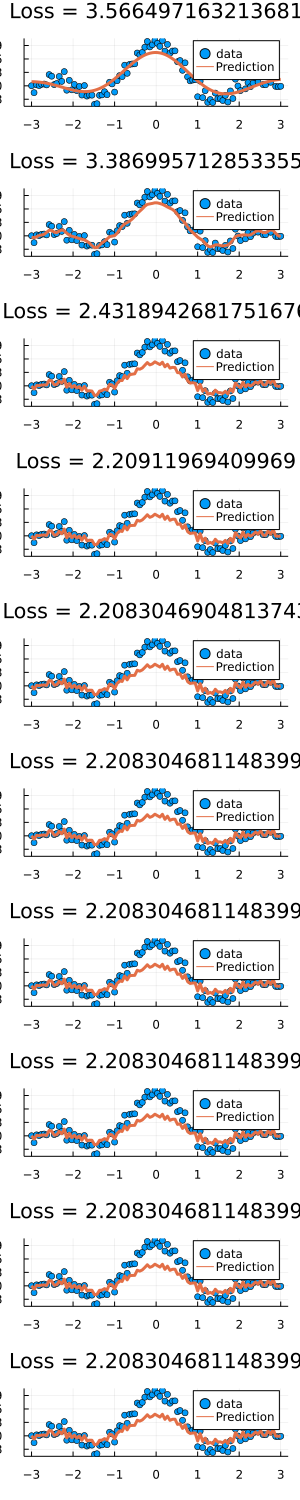

In [9]:
l = @layout grid(10, 1)
plot(plots...; layout=l, size=(300, 1500))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*